In [1]:
import torch
import numpy as np
import pandas as pd

from pathlib import Path


from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_recall_fscore_support


from datasets import Dataset

from transformers import Trainer
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import Trainer, TrainingArguments


## Global variables

In [2]:
DATASET_FOLDER = Path('emotion_analysis_comics/dataset_files')
# DATA_FILE = 'emotion_analysis_comics/bert/datasets/comics_dataset_35.pt'
RESULTS_FOLDER = 'emotion_analysis_comics/bert/outputs'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

## Load data

In [5]:
train_df = pd.read_csv(DATASET_FOLDER / "comics_dataset_train.csv")
test_df = pd.read_csv(DATASET_FOLDER / "comics_dataset_test.csv")

In [6]:
train_df.shape, test_df.shape

((5803, 11), (1326, 11))

In [7]:
emotion_map = {
    'AN': 'anger',
    'DI': 'disgust',
    'FE': 'fear',
    'SA': 'sadness',
    'SU': 'surprise',
    'JO': 'joy'
}

def extract_emotions(row):

    emotion_str = row.emotion

    if emotion_str == 'Neutral':
        return ['neutral']

    emotions = emotion_str.split('-')
    tags = []

    for emotion in emotions:
        abbrev = emotion[:2]  
        value_part = emotion[2:] 
        
        if abbrev in emotion_map and value_part.isdigit():
            value = int(value_part)
            if value > 0:
                tag = emotion_map[abbrev].lower() + ":" + str(value)
                #tags.append(emotion_map[abbrev].lower())
                tags.append(tag)
        else:
            print(f"Warning: Skipping invalid emotion entry: '{emotion}'")
    return tags  

In [8]:
train_df['utterance_emotion'] = train_df.apply(lambda row: extract_emotions(row), axis=1)
test_df['utterance_emotion'] = test_df.apply(lambda row: extract_emotions(row), axis=1)

In [9]:
def get_emotions_only(row):

    emotion_l = []

    for emotion in row.utterance_emotion:

        if emotion == 'neutral':
            emotion_l.append('neutral')
        else:
            emotion_l.append(emotion.split(":")[0])

    return emotion_l

In [10]:
train_df['emotion_only'] = train_df.apply(lambda row: get_emotions_only(row), axis=1)
test_df['emotion_only'] = test_df.apply(lambda row: get_emotions_only(row), axis=1)

In [11]:

mlb = MultiLabelBinarizer()

In [12]:
train_df['binarized_labels'] = mlb.fit_transform(train_df['emotion_only']).tolist() # type: ignore
test_df['binarized_labels'] = mlb.fit_transform(test_df['emotion_only']).tolist() # type: ignore

In [13]:
train_dataset = Dataset.from_pandas(train_df[['utterance', 'binarized_labels']])
test_dataset = Dataset.from_pandas(test_df[['utterance', 'binarized_labels']])

In [14]:
### Tokenize

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
def tokenize_function(examples):
    return tokenizer(examples['utterance'], padding="max_length", truncation=True)

In [17]:
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5803 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

In [18]:
def format_labels(examples):
    examples['labels'] = torch.tensor(examples['binarized_labels'], dtype=torch.float32)
    return examples


In [19]:
train_dataset = train_dataset.map(format_labels, batched=True)
test_dataset = test_dataset.map(format_labels, batched=True)

Map:   0%|          | 0/5803 [00:00<?, ? examples/s]

Map:   0%|          | 0/1326 [00:00<?, ? examples/s]

In [20]:
split_datasets = train_dataset.train_test_split(test_size=0.2)

train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']


In [21]:
train_dataset

Dataset({
    features: ['utterance', 'binarized_labels', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 4642
})

In [22]:
eval_dataset

Dataset({
    features: ['utterance', 'binarized_labels', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 1161
})

In [23]:
# global variables
NUM_LABELS = len(mlb.classes_)
BATCH_SIZE = 128
NB_EPOCHS = 20

In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, problem_type="multi_label_classification", device_map='cuda')
#model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model.device

device(type='cuda', index=0)

In [26]:


def compute_metrics(p):

    preds = torch.sigmoid(torch.tensor(p.predictions)).numpy()


    preds = np.where(preds > 0.5, 1, 0)


    labels = p.label_ids


    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    accuracy = (preds == labels).mean()

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [27]:
training_args = TrainingArguments(
    
    # output
    output_dir=RESULTS_FOLDER,          
    
    # params
    num_train_epochs=NB_EPOCHS,               # nb of epochs
    per_device_train_batch_size=BATCH_SIZE,   # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,    # cf. paper Sun et al.
    learning_rate=1e-5,#2e-5,                 # cf. paper Sun et al.
#     warmup_steps=500,                         # number of warmup steps for learning rate scheduler
    warmup_ratio=0.1,                         # cf. paper Sun et al.
    weight_decay=0.01,                        # strength of weight decay
    
    # eval
    eval_strategy="steps",              # cf. paper Sun et al.
    eval_steps=20,                            # cf. paper Sun et al.
    
    # log
    logging_dir="emotion_analysis_comics/bert/logs",  
    logging_strategy='steps',
    logging_steps=20,
    
    # save
    save_strategy='steps',
    save_total_limit=1,
    # save_steps=20, # default 500
    load_best_model_at_end=True,              # cf. paper Sun et al.
    # metric_for_best_model='eval_loss' 
    metric_for_best_model='f1'
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Custom metrics function
)

In [31]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,0.649500,0.637006,0.633198,0.136773,0.132929,0.285887
40,0.614600,0.579988,0.783930,0.067283,0.324263,0.047860
60,0.540900,0.499175,0.793405,0.000000,0.000000,0.000000
80,0.482700,0.467149,0.793528,0.000937,0.142857,0.000470
100,0.460900,0.453364,0.797342,0.037577,0.229592,0.021838
120,0.448000,0.445267,0.804356,0.093359,0.213832,0.063270
140,0.438100,0.437019,0.807678,0.112289,0.351292,0.076765
160,0.425600,0.432352,0.811493,0.151294,0.450360,0.111808
180,0.421600,0.427156,0.815430,0.197648,0.413575,0.144266
200,0.410800,0.423386,0.818629,0.223215,0.393082,0.164793


/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

TrainOutput(global_step=740, training_loss=0.363961589014208, metrics={'train_runtime': 2133.1295, 'train_samples_per_second': 43.523, 'train_steps_per_second': 0.347, 'total_flos': 2.4428326990848e+16, 'train_loss': 0.363961589014208, 'epoch': 20.0})

In [32]:
#model_file = os.path.join("/notebooks/cascade_bert/saved_models", 'best-model-with-real-prev-probs')

#model = BertForSequenceClassification.from_pretrained(model_file, num_labels=NUM_LABELS)
#model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [46]:
def get_predictions(model, test_dataset):
    predictions, true_labels = [], []

    for batch in test_dataset:



        input_ids = torch.tensor(batch['input_ids']).unsqueeze(0)
        attention_mask = torch.tensor(batch['attention_mask']).unsqueeze(0) 
        

        input_ids = input_ids.to(model.device)
        attention_mask = attention_mask.to(model.device)


        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()


        preds = np.where(probs > 0.5, 1, 0)

        predictions.append(preds)

        true_labels.append(batch['labels'])

    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)

    return predictions, true_labels

In [47]:
predictions, true_labels = get_predictions(model, test_dataset)

In [48]:
print(classification_report(true_labels, predictions, target_names=mlb.classes_, digits=3)) # type: ignore

              precision    recall  f1-score   support

       anger      0.531     0.449     0.487       454
     disgust      0.000     0.000     0.000        50
        fear      0.509     0.388     0.440       299
         joy      0.515     0.465     0.488       297
     neutral      0.000     0.000     0.000       109
     sadness      0.509     0.331     0.401       344
    surprise      0.677     0.485     0.565       355

   micro avg      0.548     0.390     0.456      1908
   macro avg      0.392     0.303     0.340      1908
weighted avg      0.504     0.390     0.438      1908
 samples avg      0.461     0.397     0.409      1908



/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [50]:
conf_matrices = multilabel_confusion_matrix(true_labels, predictions)

In [51]:
def plot_confusion_matrices(conf_matrices, class_names):
    num_classes = len(class_names)
    
    # Set up the figure
    fig, axes = plt.subplots(nrows=1, ncols=num_classes, figsize=(20, 5))
    fig.suptitle('Confusion Matrices for Each Label')

    for i, ax in enumerate(axes):
        # Get confusion matrix for the current label
        cm = conf_matrices[i]
        
        # Plot the confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_title(f'Label: {class_names[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [52]:
class_names = mlb.classes_

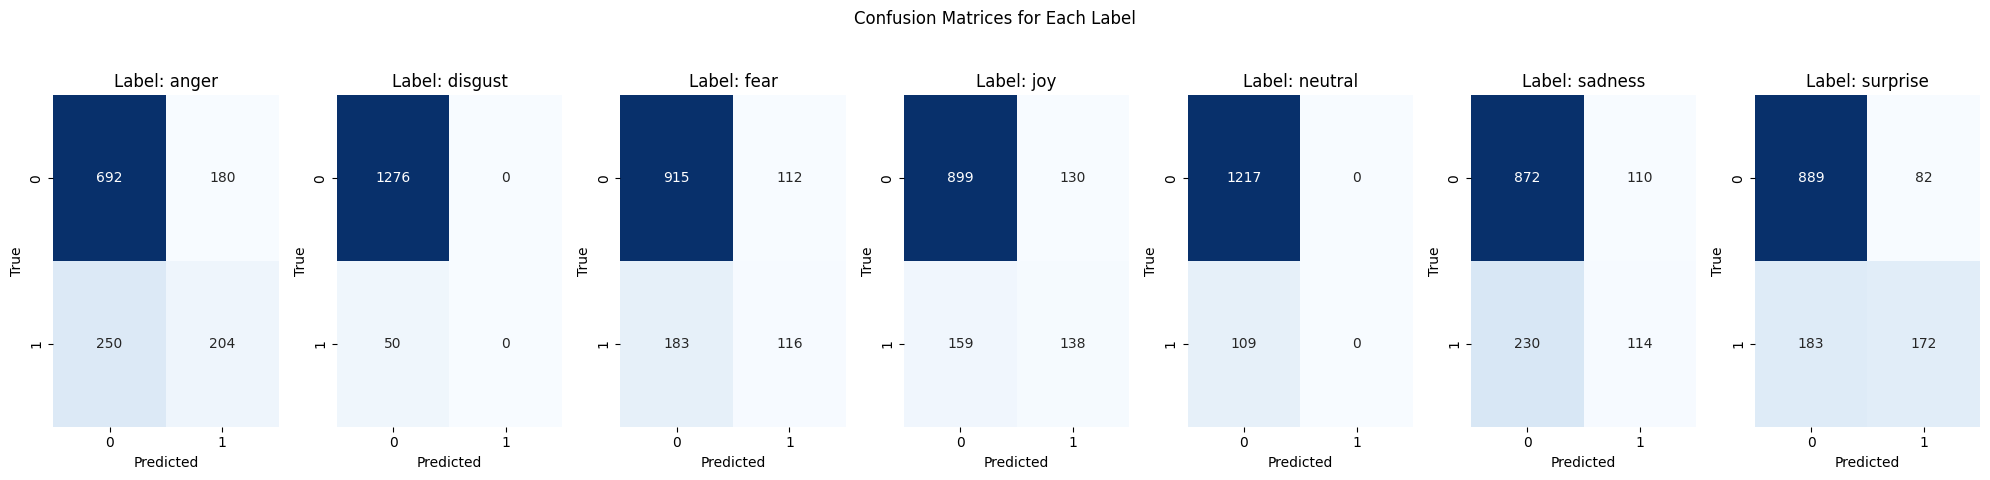

In [53]:
plot_confusion_matrices(conf_matrices, class_names)